In [16]:
import torch,copy,argparse,csv
from torch.autograd import Variable
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data

## Load data

In [17]:
velocity_coeff = np.genfromtxt('./data/POD_coeffs_3900_new_grid_221_42_Velocity_1.csv', delimiter=',')
pressure_coeff = np.genfromtxt('./data/POD_coeffs_3900_new_grid_221_42_Pressure_1.csv', delimiter=',')

In [18]:
coeff_all = torch.from_numpy(np.append(velocity_coeff,pressure_coeff,axis=0)).type(torch.FloatTensor)
data = copy.deepcopy(coeff_all[:,:-1].T)
label = copy.deepcopy(coeff_all[:,1:].T)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data,label, test_size=0.3 , random_state=2)

## Compute residuals

In [20]:
basis_v = torch.from_numpy(np.genfromtxt('./data/Velocity_basis.csv', delimiter=',')).type(torch.FloatTensor)
basis_p = torch.from_numpy(np.genfromtxt('./data/Pressure_basis.csv', delimiter=',')).type(torch.FloatTensor)

In [21]:
def backward_p(coeff_p, basis_p):
    length, number = coeff_p.shape
    nx = 221
    ny = 42
    grid_p = torch.matmul(basis_p, coeff_p)
    return grid_p.reshape(nx,ny,number)

In [22]:
def backward_v(coeff_v, basis_v):
    length, number = coeff_v.shape
    nx = 221
    ny = 42
    grid_v = torch.matmul(basis_v, coeff_v)
    grid_v1 = grid_v[0:nx*ny].reshape(nx,ny,number)
    grid_v2 = grid_v[nx*ny:].reshape(nx,ny,number)
    return grid_v1, grid_v2

In [23]:
def backward(coeff, basis_v, basis_p):
    nPOD = 10
    coeff_v = coeff[:nPOD,:]
    coeff_p = coeff[nPOD:,:]
    v1, v2 = backward_v(coeff_v, basis_v)
    p = backward_p(coeff_p, basis_p)
    return v1, v2, p

In [24]:
def compute_resids(coeff, coeff_pred, basis_v, basis_p):
    u1_o1d, u2_o1d, p = backward(coeff, basis_v, basis_p)
    u1, u2, p = backward(coeff_pred, basis_v, basis_p)
    nx, ny = 221,42
    dx, dy = 0.01, 0.01
    dt = 1.
    sigma = 0.
    rho = 1.
    mu = 1./300
    # first order term of u1
    u1x = (u1[2:,1:-1] - u1[:-2,1:-1])/(2.0*dx)
    u1y = (u1[1:-1,2:] - u1[1:-1,:-2])/(2.0*dy)
#     u1t = (u1_new[1:-1, 1:-1] - u1 [1:-1, 1:-1] )/dt 
    u1t = (u1[1:-1, 1:-1] - u1_o1d[1:-1, 1:-1])/dt 
    # second order term of u1 
    u1xx = (u1[2:,1:-1] - 2. *u1[1:-1, 1:-1] + u1[0: -2, 1:-1])/(dx**2) 
    u1yy = (u1[1:-1,2:] - 2. *u1[1:-1, 1:-1] + u1[1:-1, 0:-2])/(dy**2) 
    # first order term of u2
    u2x = (u2[2:,1:-1] - u2[0:-2, 1:-1])/(2.0*dx) 
    u2y = (u2[1:-1, 2: ] - u2 [1:-1, 0:-2])/(2.0*dy) 
#     u2t = (u2_new[1:-1, 1:-1] - u2 [1:-1, 1:-1] )/dt 
    u2t = (u2[1:-1, 1:-1] - u2_o1d[1:-1, 1:-1] )/dt 
    # second order term of u2 
    u2xx = (u2[2:,1:-1] - 2.*u2[1:-1, 1:-1] + u2[0:-2, 1:-1])/(dx**2) 
    u2yy = (u2[1:-1,2:] - 2.*u2[1:-1, 1:-1] + u2[1:-1, 0:-2])/(dy**2) 
    # first order of p 
    px = (p[2:,1:-1] - p[0:-2,1:-1])/(2.* dx)
    py = (p[1:-1,2:] - p[1:-1,0:-2])/(2.* dy)
    r_cty = u1x + u2y 
    r_u1 = rho*u1t + sigma*u1 [1:-1, 1:-1]+ rho* (u1 [1:-1, 1:-1] *u1x+u2 [1:-1, 1:-1] *u1y) - mu* (u1xx+u1yy) + px
    r_u2 = rho*u2t + sigma*u2 [1: -1, 1: -1]+ rho* (u1 [1:-1, 1:-1] *u2x+u2 [1:-1, 1:-1] *u2y) - mu* (u2xx+u2yy) + py
    return r_cty, r_u1, r_u2

## Build model

In [25]:
## ========================模型验证======================
def valid(model,data,criterion):
    model.eval()
    z = torch.from_numpy(np.random.randn(data.shape[0], 10)).float() # 随机噪声
    with torch.no_grad():   # 不记录梯度信息
        y_pred = model(torch.cat([z, data], dim=1))
        loss = criterion(y_pred, y_test)
        loss_val.append(loss.item())
        print('val MSE loss:',loss.item())

In [26]:
# 网络G，用于预测下一时刻的特征向量
G = torch.nn.Sequential(
    torch.nn.Linear(20+10,30),   # 特征向量+噪声向量
    torch.nn.ReLU(),   
    torch.nn.Linear(30,15), 
    torch.nn.ReLU(),   
    torch.nn.Linear(15,20),   
)
# 网络D，用于一组特征向量是网络G制造的还是真实标签，促使G的输出接近于真实标签
D = torch.nn.Sequential(
    torch.nn.Linear(20,10),   
    torch.nn.ReLU(),   
    torch.nn.Linear(10,5), 
    torch.nn.ReLU(),   
    torch.nn.Linear(5,1),
    nn.Sigmoid()   
)

In [27]:
loss_func_bce = nn.BCELoss()    # 用于鉴别器模型D（对抗损失），D的任务判断是否为标签，属于二分类任务，因此用交叉熵损失
loss_func_reg = nn.MSELoss()    # 用于生成器G，计算模型预测和标签的差异，因为是回归任务所以用均方根损失
opt_g = torch.optim.Adam(G.parameters(), lr=3e-4)   
opt_d = torch.optim.Adam(D.parameters(), lr=1e-4)

In [28]:
loss_train = []
loss_val = []

## Training

In [29]:
dataset_train = Data.TensorDataset(x_train , y_train)
batch_size = 60
loader = Data.DataLoader(
    dataset = dataset_train,
    batch_size = batch_size,
    shuffle=True,
    num_workers = 8
)
epochs = 10
lambda_res = 0.01

In [31]:
for epoch in range(epochs):
    print('epoch:',epoch)
    for step , (batch_x,batch_y) in enumerate(loader):
        # 训练判别器D，目的是能够区分G的输出和真实标签
        for d in range(1):
            D.train()
            G.eval()
            # 前向传播
            z=torch.from_numpy(np.random.randn(batch_x.shape[0], 10)).float()   # 随机噪声
            d_real = D(batch_y)     #  （标签）输入判别器的结果
            batch_y_pred = G(torch.cat([z, batch_x], dim=1))      #  （噪声+x）输入生成器，得到预测结果
            d_gen = D(batch_y_pred)        #  （预测结果）输入判别器的结果
            # 计算损失
            Dloss_real = loss_func_bce(d_real, torch.ones((batch_x.shape[0],1))) # 对于（标签+x）组，判别器输出应趋向于全1
            Dloss_gen = loss_func_bce(d_gen, torch.zeros((batch_x.shape[0],1)))  # 对于（预测结果+x）组，判别器输出应趋向于全0
            Dloss = Dloss_real + Dloss_gen
            # 反向传播（只对判别器参数进行更新）
            Dloss.backward()
            opt_d.step()
            opt_d.zero_grad()
            opt_g.zero_grad()
        # 训练生成器G，目的是G的输出能够欺骗D，让D以为G的输出就是真实标签
        for g in range(3):
            D.eval()
            G.train()
            # 前向传播
            z = torch.from_numpy(np.random.randn(batch_x.shape[0], 10)).float() # 随机噪声
            batch_y_pred = G(torch.cat([z, batch_x], dim=1))
            d_gen = D(batch_y_pred)  
            # 计算损失函数
            Gloss_adventure = 0.3 * loss_func_bce(d_gen, torch.ones((batch_x.shape[0],1)))   # G的目的是，让D以为它的输出就是真实标签，因此G趋向于让d_gen等于1
            Gloss_regression = loss_func_reg(batch_y_pred,batch_y)
            r_cty_pred, r_u1_pred, r_u2_pred = compute_resids(batch_x.T, batch_y_pred.T, basis_v, basis_p)
            r_cty, r_u1, r_u2 = compute_resids(batch_x.T, batch_y.T, basis_v, basis_p)
#             r_cty, r_u1, r_u2 = compute_resids(batch_y, batch_y_pred, basis_v, basis_p, scaler)
            Gloss_res = torch.norm(r_cty_pred-r_cty)+torch.norm(r_u1_pred-r_u1)+torch.norm(r_u2_pred-r_u2)
            Gloss = Gloss_regression + Gloss_adventure + lambda_res*Gloss_res
            # 反向传播
            Gloss.backward()
            opt_g.step()
            opt_g.zero_grad()
            opt_d.zero_grad()
            loss_train.append(Gloss_regression.item())
            valid(G,x_test,loss_func_reg)
        D.eval()
        G.eval()
        print('train D loss:', Dloss.detach().item(), 'G loss:', Gloss.detach().item())

epoch: 0
val MSE loss: 48.88916778564453
val MSE loss: 48.839942932128906
val MSE loss: 48.79334259033203
train D loss: 1.9866406917572021 G loss: 145.09384155273438
val MSE loss: 48.72427749633789
val MSE loss: 48.673274993896484
val MSE loss: 48.62242889404297
train D loss: 2.0287790298461914 G loss: 142.08331298828125
val MSE loss: 48.55815505981445
val MSE loss: 48.49900436401367
val MSE loss: 48.44989013671875
train D loss: 1.9576349258422852 G loss: 142.30642700195312
val MSE loss: 48.383087158203125
val MSE loss: 48.32743835449219
val MSE loss: 48.270118713378906
train D loss: 1.9688491821289062 G loss: 144.52455139160156
val MSE loss: 48.19900894165039
val MSE loss: 48.15056228637695
val MSE loss: 48.10066604614258
train D loss: 2.017115592956543 G loss: 142.1493682861328
val MSE loss: 48.03609848022461
val MSE loss: 47.9707145690918
val MSE loss: 47.91036605834961
train D loss: 1.9763200283050537 G loss: 141.29212951660156
val MSE loss: 47.85422897338867
val MSE loss: 47.80828

val MSE loss: 32.39981460571289
train D loss: 1.82481050491333 G loss: 111.17138671875
val MSE loss: 32.23309326171875
val MSE loss: 32.063846588134766
val MSE loss: 31.851449966430664
train D loss: 1.7635325193405151 G loss: 108.20721435546875
val MSE loss: 31.639211654663086
val MSE loss: 31.433963775634766
val MSE loss: 31.227947235107422
train D loss: 1.8159176111221313 G loss: 108.95518493652344
val MSE loss: 31.044973373413086
val MSE loss: 30.82695770263672
val MSE loss: 30.64451789855957
train D loss: 1.789698839187622 G loss: 108.8724365234375
val MSE loss: 30.40166473388672
val MSE loss: 30.214406967163086
val MSE loss: 29.993589401245117
train D loss: 1.7337510585784912 G loss: 107.19657135009766
val MSE loss: 29.795425415039062
val MSE loss: 29.615970611572266
val MSE loss: 29.403377532958984
train D loss: 1.823392629623413 G loss: 105.04534149169922
val MSE loss: 29.179773330688477
val MSE loss: 28.970882415771484
val MSE loss: 28.745500564575195
train D loss: 1.8196096420

val MSE loss: 8.625471115112305
val MSE loss: 8.60733413696289
val MSE loss: 8.584226608276367
train D loss: 1.5275557041168213 G loss: 49.28558349609375
val MSE loss: 8.565585136413574
val MSE loss: 8.53689956665039
val MSE loss: 8.518411636352539
train D loss: 1.5180991888046265 G loss: 49.990596771240234
val MSE loss: 8.49451732635498
val MSE loss: 8.471102714538574
val MSE loss: 8.450739860534668
train D loss: 1.5512096881866455 G loss: 49.493019104003906
val MSE loss: 8.430989265441895
val MSE loss: 8.414006233215332
val MSE loss: 8.388055801391602
train D loss: 1.5273196697235107 G loss: 48.88264083862305
val MSE loss: 8.371856689453125
val MSE loss: 8.357686042785645
val MSE loss: 8.330459594726562
train D loss: 1.512798547744751 G loss: 48.39128875732422
val MSE loss: 8.309852600097656
val MSE loss: 8.28766918182373
val MSE loss: 8.26291275024414
train D loss: 1.5035947561264038 G loss: 49.022544860839844
val MSE loss: 8.247940063476562
val MSE loss: 8.228592872619629
val MSE l

val MSE loss: 5.807284355163574
val MSE loss: 5.785455703735352
val MSE loss: 5.77497673034668
train D loss: 1.4802299737930298 G loss: 33.47673034667969
val MSE loss: 5.753509998321533
val MSE loss: 5.735325336456299
val MSE loss: 5.724841117858887
train D loss: 1.4844355583190918 G loss: 34.148765563964844
val MSE loss: 5.703293800354004
val MSE loss: 5.678819179534912
val MSE loss: 5.668346881866455
train D loss: 1.479168176651001 G loss: 32.527740478515625
val MSE loss: 5.644989490509033
val MSE loss: 5.624570846557617
val MSE loss: 5.618903636932373
train D loss: 1.474243402481079 G loss: 32.91834259033203
val MSE loss: 5.597048759460449
val MSE loss: 5.579452991485596
val MSE loss: 5.56696891784668
train D loss: 1.5067881345748901 G loss: 35.29404830932617
val MSE loss: 5.548500061035156
val MSE loss: 5.529661655426025
val MSE loss: 5.51669979095459
train D loss: 1.4780304431915283 G loss: 33.73849105834961
val MSE loss: 5.495203018188477
val MSE loss: 5.479863166809082
val MSE l

val MSE loss: 3.855400800704956
val MSE loss: 3.842719793319702
val MSE loss: 3.834057569503784
train D loss: 1.467455506324768 G loss: 21.595788955688477
val MSE loss: 3.8224997520446777
val MSE loss: 3.8191096782684326
val MSE loss: 3.810004949569702
train D loss: 1.4650137424468994 G loss: 21.495201110839844
val MSE loss: 3.8028085231781006
val MSE loss: 3.7956597805023193
val MSE loss: 3.789846897125244
train D loss: 1.467280387878418 G loss: 22.873451232910156
val MSE loss: 3.7779221534729004
val MSE loss: 3.7685065269470215
val MSE loss: 3.7675840854644775
train D loss: 1.4673879146575928 G loss: 23.399993896484375
val MSE loss: 3.761155605316162
val MSE loss: 3.7512450218200684
val MSE loss: 3.744197368621826
train D loss: 1.4431612491607666 G loss: 14.252433776855469
epoch: 9
val MSE loss: 3.7374799251556396
val MSE loss: 3.7296836376190186
val MSE loss: 3.718184232711792
train D loss: 1.4392657279968262 G loss: 20.26156997680664
val MSE loss: 3.7087242603302
val MSE loss: 3.69

GAN_with_noise——测试集均方误差： 3.0823421478271484


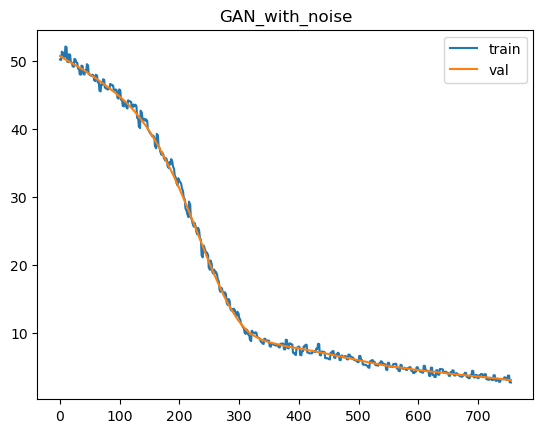

In [34]:
x = [i for i in range(len(loss_train))]    # 每一轮G都训练了3次，所以乘3
plt.plot(x,loss_train, label='train')
plt.plot(x,loss_val, label='val')
plt.title('GAN_with_noise')
plt.legend()
plt.savefig(fname="results/GAN_with_noise.png")
np.save('results/GAN_with_noise.npy',loss_train)   # 保存为npy文件,供不同方法对比
print('GAN_with_noise——测试集均方误差：',loss_val[-1])
plt.show()

In [35]:
G.eval()
z = torch.from_numpy(np.random.randn(data.shape[0], 10)).float() # 随机噪声
coeff_pred = G(torch.cat([z, data], dim=1))
np.savetxt('./results/prediction_res_GAN.csv', coeff_pred.detach().numpy(), delimiter=',')